<a href="https://colab.research.google.com/github/zenikigai/Pengembangan_Machine_Learning_IDcamp2023/blob/main/Image_Classification__Model__Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4 star rating after submission.

In [1]:
!gdown 10gGn_H6xdZ8j4cttXJ5Hp6d5HW2qztYO

Downloading...
From: https://drive.google.com/uc?id=10gGn_H6xdZ8j4cttXJ5Hp6d5HW2qztYO
To: /content/dog_cat_panda.zip
100% 394M/394M [00:04<00:00, 81.7MB/s]


In [2]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Conv2D, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import files
from IPython.display import Image, display
from keras.preprocessing import image
import numpy as np

In [3]:
def extract_dataset(zip_path, extract_path):
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

zip_file_path = "/content/dog_cat_panda.zip"
extracted_dir = "/content/"
os.makedirs(extracted_dir, exist_ok=True)
extract_dataset(zip_file_path, extracted_dir)

In [4]:
def print_class_samples(dataset_dir):
    classes = sorted(os.listdir(dataset_dir))
    for class_name in classes:
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            num_samples = len(os.listdir(class_path))
            print(f"Class: {class_name}, Jumlah sampel: {num_samples}")

print_class_samples("/content/animals/animals")

Class: cats, Jumlah sampel: 1000
Class: dogs, Jumlah sampel: 1000
Class: panda, Jumlah sampel: 1000


In [18]:
dataset_dir = "/content/animals/animals"

In [19]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

In [20]:
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical",
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical",
    subset="validation"
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [21]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet", input_tensor=None, classes=3)
base_model.trainable = False

model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                      

In [22]:
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=2
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [23]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7633
Epoch 1: val_accuracy improved from -inf to 0.90833, saving model to best_model.h5
19/19 [==============================] - 193s 10s/step - loss: 0.5901 - accuracy: 0.7633 - val_loss: 0.2838 - val_accuracy: 0.9083
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9417
Epoch 2: val_accuracy improved from 0.90833 to 0.94333, saving model to best_model.h5
19/19 [==============================] - 189s 10s/step - loss: 0.1785 - accuracy: 0.9417 - val_loss: 0.2560 - val_accuracy: 0.9433
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9513
Epoch 3: val_accuracy improved from 0.94333 to 0.94833, saving model to best_model.h5
19/19 [==============================] - 201s 11s/step - loss: 0.1345 - accuracy: 0.9513 - val_loss: 0.2181 - val_accuracy: 0.9483
Epoch 4/5
19/19 [==============================] - ETA: 0s - loss: 0.1121

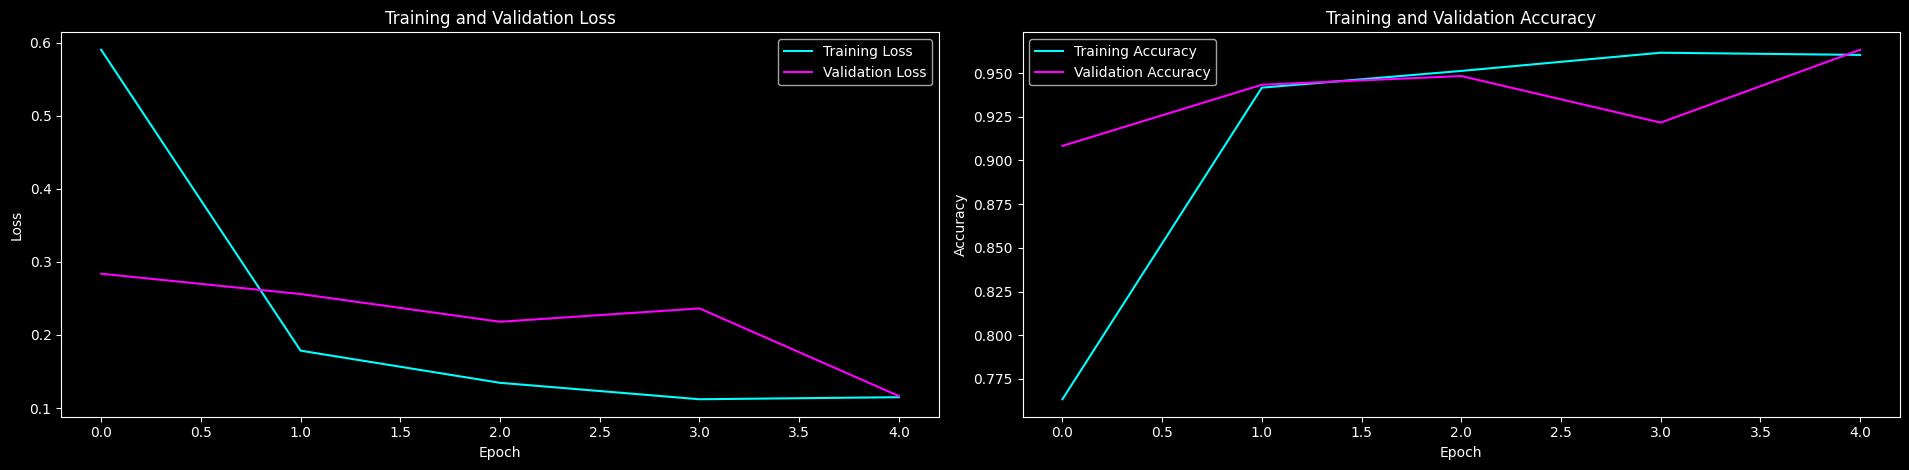

In [24]:
plt.style.use('dark_background')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19.2, 4.8))

axes[0].plot(hist.history["loss"], label="Training Loss", color='cyan')
axes[0].plot(hist.history["val_loss"], label="Validation Loss", color='magenta')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()

axes[1].plot(hist.history["accuracy"], label="Training Accuracy", color='cyan')
axes[1].plot(hist.history["val_accuracy"], label="Validation Accuracy", color='magenta')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig("model_plot.png")
plt.show()


Saving dog.jpg to dog.jpg
1/1 [==============================] - 1s 1s/step


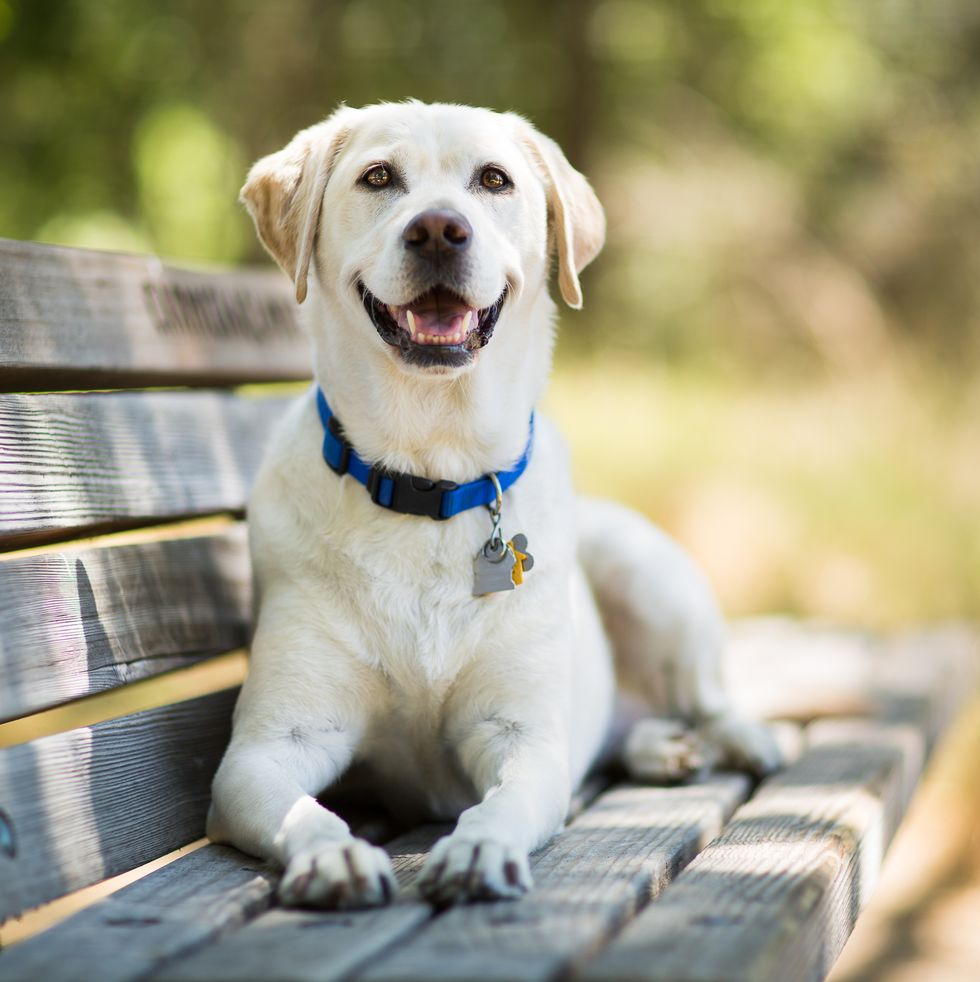

Predicted Class: dogs


In [25]:
class_mapping = {0: 'cats', 1: 'dogs', 2: 'panda'}
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    predicted_class = class_mapping[predicted_class_index]

    return predicted_class

uploaded = files.upload()

img_path = list(uploaded.keys())[0]

predicted_class = predict_image(img_path)

display(Image(img_path))
print("Predicted Class:", predicted_class)

In [26]:
model.save("cats_dogs_panda_classification_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
